<a href="https://colab.research.google.com/github/yyqbb/DATA301-Project/blob/main/clothing_reviews_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a seperate noteboook for my project dedicated solely to exploratory data analysis to understand my dataset better.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import dask.bag as db
import json

# Specify the path to the saved files in Google Drive
input_path = '/content/drive/MyDrive/processed_data.json'

# Load the processed data from Google Drive
data_bag = db.read_text(input_path).map(json.loads)

# Display the Dask bag
print(data_bag)
data_bag.take(10)

Mounted at /content/drive
dask.bag<loads, npartitions=1>


({'body type': 'hourglass',
  'rating': '10',
  'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
  'fit': 'fit'},
 {'body type': 'straight & narrow',
  'rating': '10',
  'review_text': 'I rented this dress for a photo shoot. The theme was "Hollywood Glam and Big Beautiful Hats". The dress was very comfortable and easy to move around in. It is definitely on my list to rent again for another formal event. ',
  'fit': 'fit'},
 {'body type': 'pear',
  'rating': '8',
  'review_text': "I rented this for my company's black tie awards banquet.  I liked that this dress was short but was a little fancier with the sequins. (I generally don't care for long dresses.)  I would describe the color as more rose gold than yellow gold.  I have blonde hair and fair skin, and the color was very flattering.  This is a v

In [ ]:
# Import Dask DataFrame
import dask.dataframe as dd

# Convert Dask bag to Dask DataFrame
data_df = data_bag.to_dataframe()

# Convert 'rating' column to numerical values (assuming it's a string)
data_df['rating'] = data_df['rating'].astype(float)

# Group by 'body_type' and calculate the mean rating
mean_ratings = data_df.groupby('body type')['rating'].mean()

# Sort mean ratings from highest to lowest
mean_ratings_sorted = mean_ratings.nlargest(n=len(mean_ratings))

# Trigger computation if needed
mean_ratings_sorted_computed = mean_ratings_sorted.compute()

# Print sorted mean ratings for each body type
print(mean_ratings_sorted_computed)

body type
straight & narrow    9.157338
athletic             9.122010
petite               9.079732
hourglass            9.077783
pear                 9.041399
full bust            9.022468
apple                8.928030
Name: rating, dtype: float64


In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

STOP_WORDS = set(stopwords.words('english'))
print(STOP_WORDS)

{'with', 'being', 'have', 'are', 'if', 'such', 'who', 'under', 'we', 'our', 'this', 'needn', 'while', 'ma', 'and', "mightn't", 'against', 'nor', "couldn't", 'your', 'you', 'few', 'shan', 'ourselves', 'is', "isn't", 'no', 'because', 'than', 'very', 'ain', 'were', 'don', "you'll", 'does', "you're", 'there', 'same', 'mustn', 'should', 'she', 'through', 'once', 'an', 'my', 'ours', 'themselves', "it's", 'wouldn', 'the', 'all', "aren't", 'can', 'for', 'more', "you'd", 'her', 'further', 'just', 're', "needn't", 'after', 'on', 'before', 'haven', 'any', 'having', 'over', 'hasn', "wouldn't", 'he', 'me', 'until', 'again', 'off', 'shouldn', 'him', 'but', "won't", 'when', "didn't", "mustn't", 'y', 'its', "that'll", "weren't", 'whom', 'where', 's', 'a', 'both', 'or', 'up', 've', 'those', 'am', 'to', 'own', 'doing', 'some', 'mightn', 'was', 'their', 'yourselves', 'herself', 'here', 'out', 'not', 'aren', "shan't", 'couldn', 'between', 'o', 'that', 'been', 'be', 'about', "hadn't", "doesn't", 'i', 'at',

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
from nltk.util import ngrams

def remove_nonletters(word):
    return re.sub(r'[^a-zA-Z]', '', word)

def process_line(entry):
    results = []
    body_type = entry['body type']
    # removes punctuation and converts to lowercase
    review = re.sub(r'[^a-zA-Z ]', '', entry['review_text'].lower())
    # Tokenize the review into words
    words = review.split()
    # Generate trigrams
    trigrams_list = list(ngrams(words, 3))
    # Filter out trigrams containing stop words and non-letter characters
    trigrams_cleaned = [' '.join(trigram) for trigram in trigrams_list if all(word not in STOP_WORDS for word in trigram) and all(re.match(r'^[a-zA-Z]+$', word) for word in trigram)]
    return [(body_type, trigram) for trigram in trigrams_cleaned]

# Load the processed data from Google Drive using Dask bag
data_bag = db.read_text(input_path).map(json.loads)

# Process the lines to extract relevant information
trigrams_bag = data_bag.map(process_line).flatten()

# Convert Dask bag to Dask DataFrame
trigrams_df = trigrams_bag.to_dataframe(columns=['body type', 'trigram'])

# Group by 'body type' and 'trigram', then count occurrences
trigrams_with_counts = trigrams_df.groupby(['body type', 'trigram']).size().to_frame('counts').reset_index()

# Print the top ten trigrams for each body type
for body_type in trigrams_with_counts['body type'].unique().compute():
    print(f"Top ten trigrams for {body_type} body type:")
    print(trigrams_with_counts[trigrams_with_counts['body type'] == body_type].nlargest(10, 'counts').compute())

Top ten trigrams for apple body type:
      body type                     trigram  counts
14037     apple       would definitely rent      78
10095     apple   received many compliments      53
14036     apple  would definitely recommend      43
13873     apple             wore inch heels      34
1307      apple           black tie wedding      30
5607      apple        got many compliments      30
14074     apple      would highly recommend      28
3455      apple             dress fit great      25
3459      apple         dress fit perfectly      23
3466      apple              dress fit well      23
Top ten trigrams for athletic body type:
       body type                     trigram  counts
113299  athletic       would definitely rent     968
85065   athletic   received many compliments     760
113295  athletic  would definitely recommend     636
112160  athletic             wore inch heels     510
38304   athletic         dress fit perfectly     442
113460  athletic      would hig

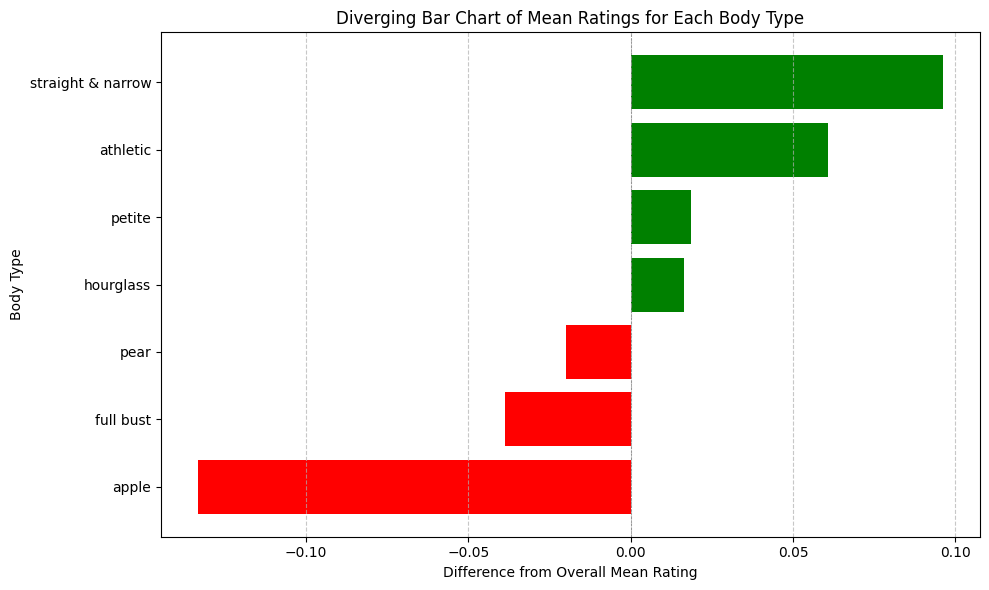

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Mean ratings for each body type
mean_ratings = {
    'straight & narrow': 9.157338,
    'athletic': 9.122010,
    'petite': 9.079732,
    'hourglass': 9.077783,
    'pear': 9.041399,
    'full bust': 9.022468,
    'apple': 8.928030
}

# Overall mean rating
overall_mean = np.mean(list(mean_ratings.values()))

# Calculate differences from the overall mean
differences = {body_type: rating - overall_mean for body_type, rating in mean_ratings.items()}

# Sort the differences
sorted_differences = sorted(differences.items(), key=lambda x: x[1])

# Extract body types and differences
body_types, diffs = zip(*sorted_differences)

# Plot diverging bar chart
plt.figure(figsize=(10, 6))
plt.barh(body_types, diffs, color=['green' if diff > 0 else 'red' for diff in diffs])
plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)  # Add a vertical line at 0
plt.title('Diverging Bar Chart of Mean Ratings for Each Body Type')
plt.xlabel('Difference from Overall Mean Rating')
plt.ylabel('Body Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
